In [1]:
import tensorflow as tf
import keras
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from datetime import datetime
#import warnings
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
from sklearn.metrics import mean_squared_error
from math import sqrt

Using TensorFlow backend.


In [2]:
class GRU_RNN:

    def __init__(self, look_back, batch_size, ip_size, dropout_probability = 0.1, init ='he_uniform', loss='mse', optimizer='adam'):
        self.rnn = Sequential()
        self.batch_size = batch_size
        self.look_back = look_back
        self.rnn.add(GRU(128, input_shape=(None, ip_size), init=init, return_sequences=True))
        self.rnn.add(Dropout(dropout_probability))
        self.rnn.add(Dense(1, init=init))
        self.rnn.compile(loss=loss, optimizer=optimizer)

    def train(self, X, Y, nb_epoch=150):
        self.rnn.fit(X, Y, nb_epoch=nb_epoch, batch_size=self.batch_size, verbose=2)

    def evaluate(self, X, Y):
        score = self.rnn.evaluate(X, Y, batch_size = self.batch_size, verbose=0)
        print(score)
        return score

    def predict(self, X):
        return self.rnn.predict(X)

In [3]:
def parser(x):
    return datetime.strptime(x, '%d-%b-%Y')

def get_data(path, date):
    data = pd.read_csv(path , header=0, parse_dates=[date], index_col=date, squeeze=True, date_parser=parser)
    return data

In [4]:
def evaluate_models(look_back, batch_size, trainX, trainY, testX, testY, ret=False):
    print('Training & evaluating GRU-RNN for batch size = ' + str(batch_size) + '...')
    (_, _, j) = trainX.shape
    if j > look_back:
        gru_model = GRU_RNN(look_back, batch_size, ip_size=j)
    else:
        gru_model = GRU_RNN(look_back, batch_size, ip_size=look_back)
    gru_model.train(trainX, trainY)
    gru_test_mse = gru_model.evaluate(testX, testY)
    print("With batch size = " + str(batch_size) + ", Score: " + str(gru_test_mse))
    print('Completed model evaluation for batch size = ' + str(batch_size) + '...')
    if ret:
        yhat = gru_model.predict(testX)
        return gru_test_mse, yhat
    del gru_model
    return gru_test_mse

In [5]:
def print_results(gru_mse_vals):
    print('Completed model evaluation for all lookback values...')
    gru_mse_min = min(gru_mse_vals)
    gru_mse_argmin = np.argmin(gru_mse_vals) + 1
    print('Best mse with a GRU recurrent neural network was ' + str(gru_mse_min) + ' with a batch size of ' + str(gru_mse_argmin))
    return gru_mse_argmin

In [6]:
np.random.seed(10)
look_back = 5

title = 'NIFTY'
x = get_data('../ml-project-data/NIFTY_train.csv', 0)
y = x.loc[: , "High":"Low"].mean(axis=1)
data_y = y       
x_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    x_lag['t-'+str(i)] = y.shift(i)
x = x_lag

x = x.iloc[look_back:]
y = y.iloc[look_back:]

act_data = get_data('../ml-project-data/NIFTY_test.csv', 0)
act = act_data.loc[: , "High":"Low"].mean(axis=1)
idx = act_data.index
act_y = act
act = pd.concat([y[-5:], act])

act_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    act_lag['t-'+str(i)] = act.shift(i)

act = act_lag[look_back:]

scaler = MinMaxScaler()
x = scaler.fit_transform(x.values)
y = scaler.fit_transform(y.values.reshape(-1, 1))
act = scaler.fit_transform(act.values)
act_y = scaler.fit_transform(act_y.values.reshape(-1, 1))

i, j = x.shape
x = x.reshape(1, i , j)
y = y.reshape(1, len(y), 1)
i,j = act.shape
act = act.reshape(1, i , j)
act_y = act_y.reshape(1, len(act_y), 1)

In [7]:
##Ran this on kaggle to get an optimum value of 22
# mse_vals = []
# for batch_size in range(1, 51):
#     np.random.seed(10)
#     mse_vals.append(evaluate_models(look_back, batch_size, x, y, act, act_y))
# min_bs = print_results(mse_vals)

In [8]:
min_bs = 22
np.random.seed(10)
mse_val, y_hat = evaluate_models(look_back, min_bs, x, y, act, act_y, True)

Training & evaluating GRU-RNN for batch size = 22...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 5), kernel_initializer="he_uniform")`
  import sys
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 1s - loss: 0.3540
Epoch 2/150
 - 0s - loss: 0.1357
Epoch 3/150
 - 0s - loss: 0.1003
Epoch 4/150
 - 0s - loss: 0.2124
Epoch 5/150
 - 0s - loss: 0.2074
Epoch 6/150
 - 0s - loss: 0.1560
Epoch 7/150
 - 0s - loss: 0.0929
Epoch 8/150
 - 0s - loss: 0.0741
Epoch 9/150
 - 0s - loss: 0.0762
Epoch 10/150
 - 0s - loss: 0.1143
Epoch 11/150
 - 0s - loss: 0.1282
Epoch 12/150
 - 0s - loss: 0.1152
Epoch 13/150
 - 0s - loss: 0.1007
Epoch 14/150
 - 0s - loss: 0.0774
Epoch 15/150
 - 0s - loss: 0.0719
Epoch 16/150
 - 0s - loss: 0.0724
Epoch 17/150
 - 0s - loss: 0.0775
Epoch 18/150
 - 0s - loss: 0.0912
Epoch 19/150
 - 0s - loss: 0.0943
Epoch 20/150
 - 0s - loss: 0.0900
Epoch 21/150
 - 0s - loss: 0.0756
Epoch 22/150
 - 0s - loss: 0.0697
Epoch 23/150
 - 0s - loss: 0.0625
Epoch 24/150
 - 0s - loss: 0.0677
Epoch 25/150
 - 0s - loss: 0.0686
Epoch 26/150
 - 0s - loss: 0.0855
Epoch 27/150
 - 0s - loss: 0.0804
Epoch 28/150
 - 0s - loss: 0.0737
Epoch 29/150
 - 0s - loss: 0.0654
Epoch 30/150
 - 0s - lo

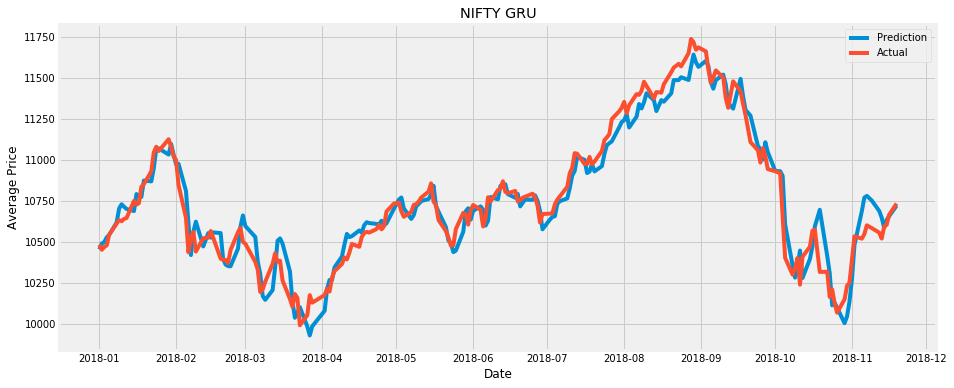

In [9]:
y_hat = y_hat.reshape(len(y_hat[0]))
act = act_y.reshape(len(act_y[0]))

preds = pd.DataFrame(y_hat,columns=['Prediction'],index=idx)
actuals = pd.DataFrame(act,columns=['Actual'],index=idx)

preds = scaler.inverse_transform(preds)
actuals = scaler.inverse_transform(actuals)

plt.figure(figsize=(14,6))
plt.plot(idx, preds, label="Prediction")
plt.plot(idx, actuals, label="Actual")
plt.ylabel("Average Price")
plt.xlabel('Date')
plt.title(title + " GRU")
plt.legend(loc="best")
plt.show()

In [10]:
rms = sqrt(mean_squared_error(actuals, preds))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print('MAPE: ' + str(mape))

RMSE: 93.81802940008629
MAPE: 0.6913757689994254


In [11]:
def company_wo_nifty(train_path, test_path, title):
    np.random.seed(10)
    look_back = 5
    
    tcs_x = get_data(train_path, 2)['Average Price']
    tcs_y = tcs_x

    tcs_x_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)
    tcs_x = tcs_x_lag

    tcs_x = tcs_x.iloc[look_back:]
    tcs_y = tcs_y.iloc[look_back:]

    tcs_act = get_data(test_path, 2)['Average Price']
    tcs_idx = tcs_act.index
    tcs_act_y = tcs_act
    tcs_act = pd.concat([tcs_y[-5:], tcs_act])

    tcs_act_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

    tcs_act = tcs_act_lag[look_back:]

    scaler = MinMaxScaler()
    tcs_x = scaler.fit_transform(tcs_x.values)
    tcs_y = scaler.fit_transform(tcs_y.values.reshape(-1, 1))
    tcs_act = scaler.fit_transform(tcs_act.values)
    tcs_act_y = scaler.fit_transform(tcs_act_y.values.reshape(-1, 1))

    i, j = tcs_x.shape
    tcs_x = tcs_x.reshape(1, i , j)
    tcs_y = tcs_y.reshape(1, len(tcs_y), 1)
    i,j = tcs_act.shape
    tcs_act = tcs_act.reshape(1, i , j)
    tcs_act_y = tcs_act_y.reshape(1, len(tcs_act_y), 1)

    # mse_vals = []
    # for batch_size in range(1, 51):
    #     np.random.seed(10)
    #     mse_vals.append(evaluate_models(look_back, batch_size, tcs_x, tcs_y, tcs_act, tcs_act_y))
    # min_bs = print_results(mse_vals)

    np.random.seed(10)
    min_bs = 35
    tcs_mse_val, tcs_y_hat = evaluate_models(look_back, min_bs, tcs_x, tcs_y, tcs_act, tcs_act_y, True)
    
    tcs_y_hat = tcs_y_hat.reshape(len(tcs_y_hat[0]))
    tcs_act = tcs_act_y.reshape(len(tcs_act_y[0]))

    tcs_preds = pd.DataFrame(tcs_y_hat,columns=['Prediction'],index=tcs_idx)
    tcs_actuals = pd.DataFrame(tcs_act,columns=['Actual'],index=tcs_idx)

    tcs_preds = scaler.inverse_transform(tcs_preds)
    tcs_actuals = scaler.inverse_transform(tcs_actuals)

    plt.figure(figsize=(14,6))
    plt.plot(tcs_idx, tcs_preds, label="Prediction")
    plt.plot(tcs_idx, tcs_actuals, label="Actual")
    plt.ylabel("Average Price")
    plt.xlabel('Date')
    plt.title(title + " GRU w/o NIFTY")
    plt.legend(loc="best")
    plt.show()
    
    rms = sqrt(mean_squared_error(tcs_actuals, tcs_preds))
    print('RMSE: ' + str(rms))

    mape = np.mean(np.abs((tcs_actuals - tcs_preds) / tcs_actuals)) * 100
    print('MAPE: ' + str(mape))

Scroll to the
end for graph..
Training & evaluating GRU-RNN for batch size = 35...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 5), kernel_initializer="he_uniform")`
  import sys
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 1s - loss: 0.4112
Epoch 2/150
 - 0s - loss: 0.1611
Epoch 3/150
 - 0s - loss: 0.1450
Epoch 4/150
 - 0s - loss: 0.2807
Epoch 5/150
 - 0s - loss: 0.2552
Epoch 6/150
 - 0s - loss: 0.1832
Epoch 7/150
 - 0s - loss: 0.1070
Epoch 8/150
 - 0s - loss: 0.1048
Epoch 9/150
 - 0s - loss: 0.1190
Epoch 10/150
 - 0s - loss: 0.1642
Epoch 11/150
 - 0s - loss: 0.1669
Epoch 12/150
 - 0s - loss: 0.1416
Epoch 13/150
 - 0s - loss: 0.1199
Epoch 14/150
 - 0s - loss: 0.0950
Epoch 15/150
 - 0s - loss: 0.0968
Epoch 16/150
 - 0s - loss: 0.1082
Epoch 17/150
 - 0s - loss: 0.1201
Epoch 18/150
 - 0s - loss: 0.1285
Epoch 19/150
 - 0s - loss: 0.1211
Epoch 20/150
 - 0s - loss: 0.1118
Epoch 21/150
 - 0s - loss: 0.0966
Epoch 22/150
 - 0s - loss: 0.0948
Epoch 23/150
 - 0s - loss: 0.0903
Epoch 24/150
 - 0s - loss: 0.1036
Epoch 25/150
 - 0s - loss: 0.1021
Epoch 26/150
 - 0s - loss: 0.1171
Epoch 27/150
 - 0s - loss: 0.1052
Epoch 28/150
 - 0s - loss: 0.0941
Epoch 29/150
 - 0s - loss: 0.0920
Epoch 30/150
 - 0s - lo

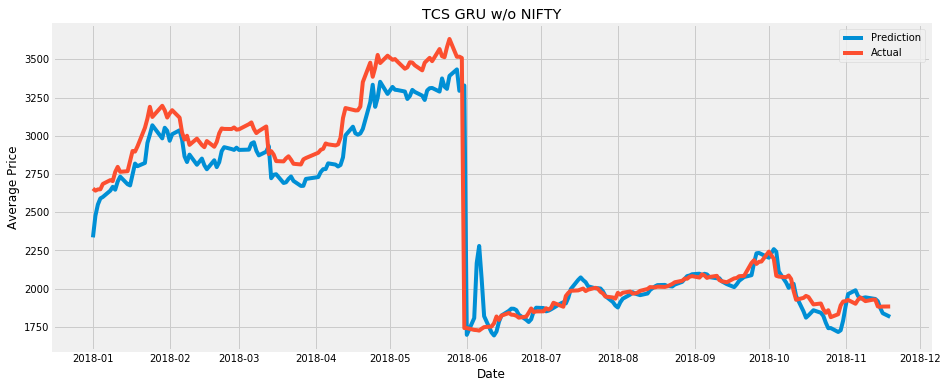

RMSE: 168.26441100954486
MAPE: 4.079932077536251


In [19]:
print('Scroll to the\nend for graph..')
company_wo_nifty('../ml-project-data/TCS_train.csv', '../ml-project-data/TCS_test.csv', 'TCS')

Scroll to the
end for graph..
Training & evaluating GRU-RNN for batch size = 35...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 5), kernel_initializer="he_uniform")`
  import sys
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 1s - loss: 0.1927
Epoch 2/150
 - 0s - loss: 0.0501
Epoch 3/150
 - 0s - loss: 0.0605
Epoch 4/150
 - 0s - loss: 0.1121
Epoch 5/150
 - 0s - loss: 0.0964
Epoch 6/150
 - 0s - loss: 0.0659
Epoch 7/150
 - 0s - loss: 0.0390
Epoch 8/150
 - 0s - loss: 0.0346
Epoch 9/150
 - 0s - loss: 0.0422
Epoch 10/150
 - 0s - loss: 0.0609
Epoch 11/150
 - 0s - loss: 0.0659
Epoch 12/150
 - 0s - loss: 0.0552
Epoch 13/150
 - 0s - loss: 0.0423
Epoch 14/150
 - 0s - loss: 0.0308
Epoch 15/150
 - 0s - loss: 0.0320
Epoch 16/150
 - 0s - loss: 0.0369
Epoch 17/150
 - 0s - loss: 0.0441
Epoch 18/150
 - 0s - loss: 0.0477
Epoch 19/150
 - 0s - loss: 0.0423
Epoch 20/150
 - 0s - loss: 0.0403
Epoch 21/150
 - 0s - loss: 0.0339
Epoch 22/150
 - 0s - loss: 0.0326
Epoch 23/150
 - 0s - loss: 0.0334
Epoch 24/150
 - 0s - loss: 0.0366
Epoch 25/150
 - 0s - loss: 0.0374
Epoch 26/150
 - 0s - loss: 0.0388
Epoch 27/150
 - 0s - loss: 0.0369
Epoch 28/150
 - 0s - loss: 0.0317
Epoch 29/150
 - 0s - loss: 0.0366
Epoch 30/150
 - 0s - lo

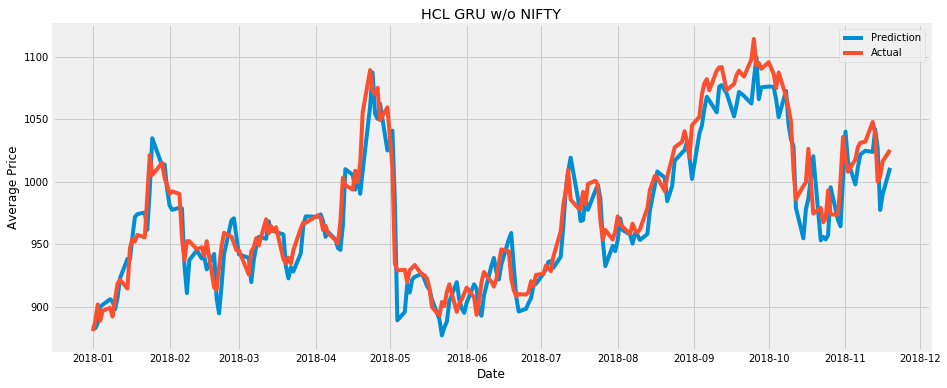

RMSE: 18.55138741470192
MAPE: 1.50993088856868


In [20]:
print('Scroll to the\nend for graph..')
company_wo_nifty('../ml-project-data/HCL_train.csv', '../ml-project-data/HCL_test.csv', 'HCL')

Scroll to the
end for graph..
Training & evaluating GRU-RNN for batch size = 35...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 5), kernel_initializer="he_uniform")`
  import sys
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 1s - loss: 0.2231
Epoch 2/150
 - 0s - loss: 0.0564
Epoch 3/150
 - 0s - loss: 0.0762
Epoch 4/150
 - 0s - loss: 0.1373
Epoch 5/150
 - 0s - loss: 0.1185
Epoch 6/150
 - 0s - loss: 0.0714
Epoch 7/150
 - 0s - loss: 0.0456
Epoch 8/150
 - 0s - loss: 0.0454
Epoch 9/150
 - 0s - loss: 0.0573
Epoch 10/150
 - 0s - loss: 0.0767
Epoch 11/150
 - 0s - loss: 0.0789
Epoch 12/150
 - 0s - loss: 0.0651
Epoch 13/150
 - 0s - loss: 0.0529
Epoch 14/150
 - 0s - loss: 0.0385
Epoch 15/150
 - 0s - loss: 0.0416
Epoch 16/150
 - 1s - loss: 0.0523
Epoch 17/150
 - 0s - loss: 0.0597
Epoch 18/150
 - 0s - loss: 0.0586
Epoch 19/150
 - 0s - loss: 0.0512
Epoch 20/150
 - 0s - loss: 0.0511
Epoch 21/150
 - 0s - loss: 0.0423
Epoch 22/150
 - 0s - loss: 0.0427
Epoch 23/150
 - 0s - loss: 0.0456
Epoch 24/150
 - 0s - loss: 0.0507
Epoch 25/150
 - 0s - loss: 0.0499
Epoch 26/150
 - 0s - loss: 0.0485
Epoch 27/150
 - 0s - loss: 0.0486
Epoch 28/150
 - 0s - loss: 0.0395
Epoch 29/150
 - 0s - loss: 0.0467
Epoch 30/150
 - 0s - lo

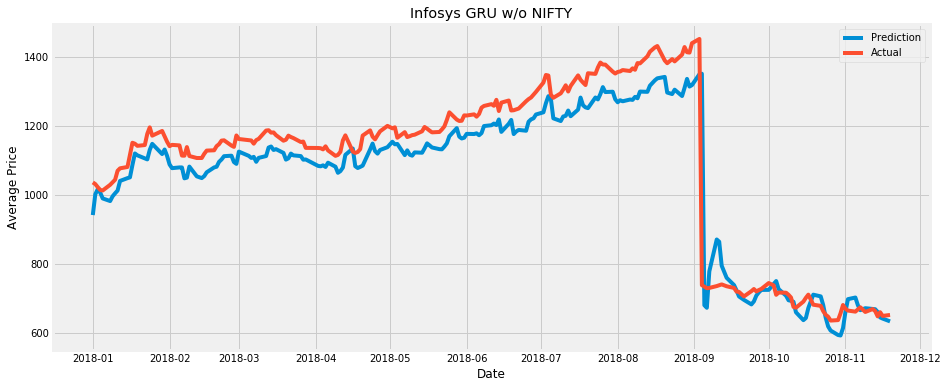

RMSE: 72.07669430453187
MAPE: 5.005412036394907


In [21]:
print('Scroll to the\nend for graph..')
company_wo_nifty('../ml-project-data/INFY_train.csv', '../ml-project-data/INFY_test.csv', 'Infosys')

Scroll to the
end for graph..
Training & evaluating GRU-RNN for batch size = 35...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 5), kernel_initializer="he_uniform")`
  import sys
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 1s - loss: 0.1757
Epoch 2/150
 - 0s - loss: 0.0472
Epoch 3/150
 - 1s - loss: 0.0633
Epoch 4/150
 - 0s - loss: 0.1098
Epoch 5/150
 - 0s - loss: 0.0892
Epoch 6/150
 - 0s - loss: 0.0607
Epoch 7/150
 - 0s - loss: 0.0386
Epoch 8/150
 - 0s - loss: 0.0375
Epoch 9/150
 - 0s - loss: 0.0456
Epoch 10/150
 - 0s - loss: 0.0613
Epoch 11/150
 - 0s - loss: 0.0639
Epoch 12/150
 - 0s - loss: 0.0549
Epoch 13/150
 - 0s - loss: 0.0415
Epoch 14/150
 - 0s - loss: 0.0309
Epoch 15/150
 - 0s - loss: 0.0344
Epoch 16/150
 - 0s - loss: 0.0398
Epoch 17/150
 - 0s - loss: 0.0482
Epoch 18/150
 - 0s - loss: 0.0473
Epoch 19/150
 - 0s - loss: 0.0400
Epoch 20/150
 - 0s - loss: 0.0398
Epoch 21/150
 - 0s - loss: 0.0332
Epoch 22/150
 - 0s - loss: 0.0341
Epoch 23/150
 - 0s - loss: 0.0381
Epoch 24/150
 - 0s - loss: 0.0407
Epoch 25/150
 - 0s - loss: 0.0398
Epoch 26/150
 - 0s - loss: 0.0395
Epoch 27/150
 - 0s - loss: 0.0375
Epoch 28/150
 - 0s - loss: 0.0319
Epoch 29/150
 - 0s - loss: 0.0388
Epoch 30/150
 - 0s - lo

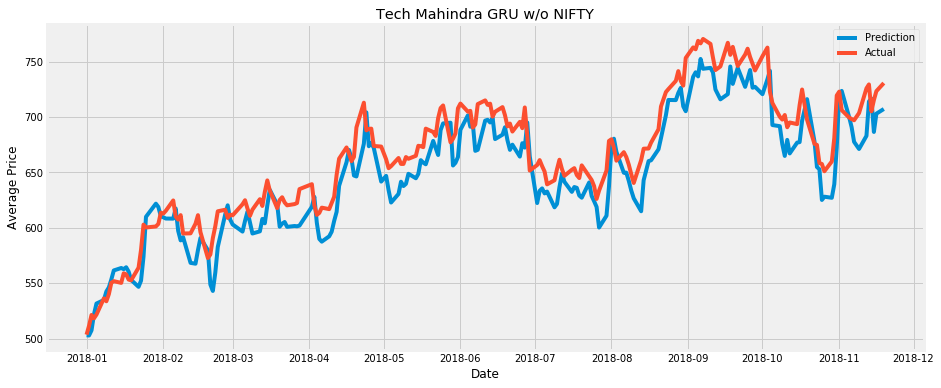

RMSE: 22.068647046392297
MAPE: 2.833410264689146


In [12]:
print('Scroll to the\nend for graph..')
company_wo_nifty('../ml-project-data/TECHM_train.csv', '../ml-project-data/TECHM_test.csv', 'Tech Mahindra')

Scroll to the
end for graph..
Training & evaluating GRU-RNN for batch size = 35...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 5), kernel_initializer="he_uniform")`
  import sys
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 2s - loss: 0.4078
Epoch 2/150
 - 0s - loss: 0.1082
Epoch 3/150
 - 0s - loss: 0.1224
Epoch 4/150
 - 0s - loss: 0.2309
Epoch 5/150
 - 0s - loss: 0.2078
Epoch 6/150
 - 0s - loss: 0.1450
Epoch 7/150
 - 0s - loss: 0.0877
Epoch 8/150
 - 0s - loss: 0.0896
Epoch 9/150
 - 0s - loss: 0.1004
Epoch 10/150
 - 0s - loss: 0.1366
Epoch 11/150
 - 0s - loss: 0.1369
Epoch 12/150
 - 0s - loss: 0.1157
Epoch 13/150
 - 1s - loss: 0.1001
Epoch 14/150
 - 1s - loss: 0.0808
Epoch 15/150
 - 1s - loss: 0.0800
Epoch 16/150
 - 0s - loss: 0.0934
Epoch 17/150
 - 0s - loss: 0.1028
Epoch 18/150
 - 1s - loss: 0.1079
Epoch 19/150
 - 0s - loss: 0.0975
Epoch 20/150
 - 0s - loss: 0.0895
Epoch 21/150
 - 0s - loss: 0.0818
Epoch 22/150
 - 0s - loss: 0.0786
Epoch 23/150
 - 0s - loss: 0.0792
Epoch 24/150
 - 0s - loss: 0.0916
Epoch 25/150
 - 0s - loss: 0.0864
Epoch 26/150
 - 0s - loss: 0.0952
Epoch 27/150
 - 0s - loss: 0.0874
Epoch 28/150
 - 0s - loss: 0.0764
Epoch 29/150
 - 0s - loss: 0.0809
Epoch 30/150
 - 1s - lo

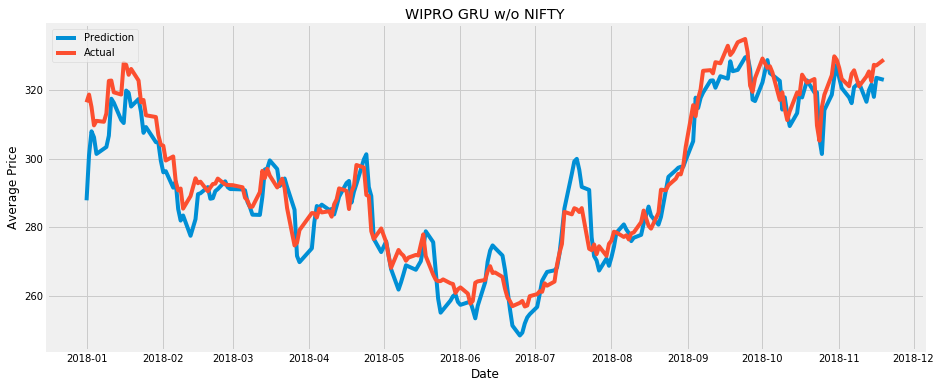

RMSE: 6.266118930719043
MAPE: 1.648842915024443


In [23]:
print('Scroll to the\nend for graph..')
company_wo_nifty('../ml-project-data/WIPRO_train.csv', '../ml-project-data/WIPRO_test.csv', 'WIPRO')

In [13]:
def company_w_nifty(train_path, test_path, title):
    np.random.seed(10)
    look_back = 5
    tcs_x = get_data(train_path, 2)['Average Price']
    tcs_y = tcs_x

    tcs_x_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)
    tcs_x = tcs_x_lag

    tcs_x = tcs_x.iloc[look_back:]
    tcs_y = tcs_y.iloc[look_back:]

    tcs_act = get_data(test_path, 2)['Average Price']
    tcs_idx = tcs_act.index
    tcs_act_y = tcs_act
    tcs_act = pd.concat([tcs_y[-5:], tcs_act])

    tcs_act_lag = pd.DataFrame()
    for i in range(look_back,0,-1):
        tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

    tcs_act = tcs_act_lag[look_back:]

    tcs_x['nifty'] = data_y
    tcs_act['nifty'] = preds

    scaler = MinMaxScaler()
    tcs_x = scaler.fit_transform(tcs_x.values)
    tcs_y = scaler.fit_transform(tcs_y.values.reshape(-1, 1))
    tcs_act = scaler.fit_transform(tcs_act.values)
    tcs_act_y = scaler.fit_transform(tcs_act_y.values.reshape(-1, 1))

    i, j = tcs_x.shape
    tcs_x = tcs_x.reshape(1, i , j)
    tcs_y = tcs_y.reshape(1, len(tcs_y), 1)
    i,j = tcs_act.shape
    tcs_act = tcs_act.reshape(1, i , j)
    tcs_act_y = tcs_act_y.reshape(1, len(tcs_act_y), 1)
    
    # mse_vals = []
    # for batch_size in range(1, 51):
    #     np.random.seed(10)
    #     mse_vals.append(evaluate_models(look_back, batch_size, tcs_x, tcs_y, tcs_act, tcs_act_y))
    # min_bs = print_results(mse_vals)
    
    np.random.seed(10)
    min_bs = 32
    tcs_mse_val, tcs_y_hat = evaluate_models(look_back, min_bs, tcs_x, tcs_y, tcs_act, tcs_act_y, True)
    
    tcs_y_hat = tcs_y_hat.reshape(len(tcs_y_hat[0]))
    tcs_act = tcs_act_y.reshape(len(tcs_act_y[0]))

    tcs_preds = pd.DataFrame(tcs_y_hat,columns=['Prediction'],index=idx)
    tcs_actuals = pd.DataFrame(tcs_act,columns=['Actual'],index=idx)

    tcs_preds = scaler.inverse_transform(tcs_preds)
    tcs_actuals = scaler.inverse_transform(tcs_actuals)
    
    plt.figure(figsize=(14,6))
    plt.plot(tcs_idx, tcs_preds, label="Prediction")
    plt.plot(tcs_idx, tcs_actuals, label="Actual")
    plt.ylabel("Average Price")
    plt.xlabel('Date')
    plt.title(title + " GRU w NIFTY")
    plt.legend(loc="best")
    plt.show()
    
    rms = sqrt(mean_squared_error(tcs_actuals, tcs_preds))
    print('RMSE: ' + str(rms))

    mape = np.mean(np.abs((tcs_actuals - tcs_preds) / tcs_actuals)) * 100
    print('MAPE: ' + str(mape))

Scroll to the
end for graph..


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 6), kernel_initializer="he_uniform")`
  import sys


Training & evaluating GRU-RNN for batch size = 32...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 2s - loss: 0.3351
Epoch 2/150
 - 0s - loss: 0.1119
Epoch 3/150
 - 0s - loss: 0.1945
Epoch 4/150
 - 0s - loss: 0.2384
Epoch 5/150
 - 0s - loss: 0.1618
Epoch 6/150
 - 0s - loss: 0.1155
Epoch 7/150
 - 0s - loss: 0.0943
Epoch 8/150
 - 0s - loss: 0.1284
Epoch 9/150
 - 0s - loss: 0.1384
Epoch 10/150
 - 0s - loss: 0.1493
Epoch 11/150
 - 0s - loss: 0.1132
Epoch 12/150
 - 0s - loss: 0.0916
Epoch 13/150
 - 0s - loss: 0.0949
Epoch 14/150
 - 0s - loss: 0.0950
Epoch 15/150
 - 0s - loss: 0.1024
Epoch 16/150
 - 0s - loss: 0.1160
Epoch 17/150
 - 0s - loss: 0.1089
Epoch 18/150
 - 0s - loss: 0.0981
Epoch 19/150
 - 0s - loss: 0.0862
Epoch 20/150
 - 0s - loss: 0.0884
Epoch 21/150
 - 0s - loss: 0.0872
Epoch 22/150
 - 0s - loss: 0.0978
Epoch 23/150
 - 0s - loss: 0.0928
Epoch 24/150
 - 0s - loss: 0.0936
Epoch 25/150
 - 0s - loss: 0.0854
Epoch 26/150
 - 0s - loss: 0.0876
Epoch 27/150
 - 0s - loss: 0.0884
Epoch 28/150
 - 0s - loss: 0.0903
Epoch 29/150
 - 0s - loss: 0.0894
Epoch 30/150
 - 0s - lo

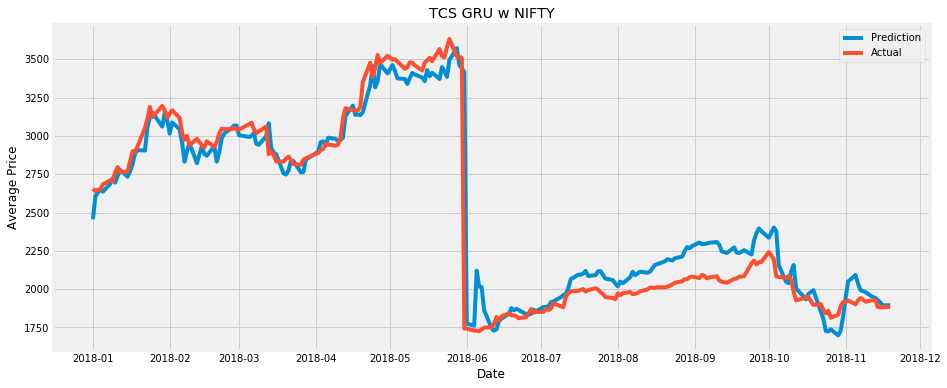

RMSE: 159.97215954810648
MAPE: 4.328941096073781


In [25]:
print('Scroll to the\nend for graph..')
company_w_nifty('../ml-project-data/TCS_train.csv', '../ml-project-data/TCS_test.csv', 'TCS')

Scroll to the
end for graph..


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 6), kernel_initializer="he_uniform")`
  import sys


Training & evaluating GRU-RNN for batch size = 32...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 2s - loss: 0.4748
Epoch 2/150
 - 0s - loss: 0.1646
Epoch 3/150
 - 0s - loss: 0.0573
Epoch 4/150
 - 0s - loss: 0.1126
Epoch 5/150
 - 0s - loss: 0.1775
Epoch 6/150
 - 0s - loss: 0.1814
Epoch 7/150
 - 0s - loss: 0.1464
Epoch 8/150
 - 0s - loss: 0.0950
Epoch 9/150
 - 0s - loss: 0.0627
Epoch 10/150
 - 0s - loss: 0.0575
Epoch 11/150
 - 0s - loss: 0.0677
Epoch 12/150
 - 0s - loss: 0.0800
Epoch 13/150
 - 0s - loss: 0.0858
Epoch 14/150
 - 0s - loss: 0.0909
Epoch 15/150
 - 0s - loss: 0.0834
Epoch 16/150
 - 0s - loss: 0.0703
Epoch 17/150
 - 0s - loss: 0.0593
Epoch 18/150
 - 0s - loss: 0.0583
Epoch 19/150
 - 0s - loss: 0.0518
Epoch 20/150
 - 0s - loss: 0.0625
Epoch 21/150
 - 0s - loss: 0.0579
Epoch 22/150
 - 0s - loss: 0.0598
Epoch 23/150
 - 0s - loss: 0.0550
Epoch 24/150
 - 0s - loss: 0.0555
Epoch 25/150
 - 0s - loss: 0.0493
Epoch 26/150
 - 0s - loss: 0.0491
Epoch 27/150
 - 0s - loss: 0.0515
Epoch 28/150
 - 0s - loss: 0.0470
Epoch 29/150
 - 0s - loss: 0.0544
Epoch 30/150
 - 0s - lo

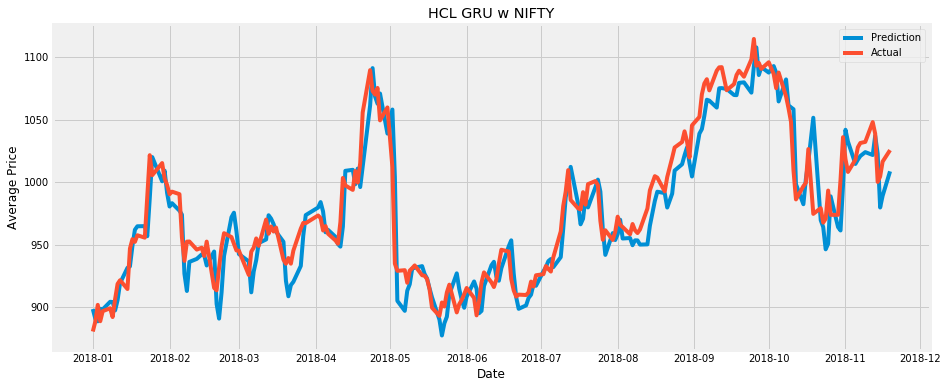

RMSE: 18.916583864554838
MAPE: 1.5110284816595936


In [26]:
print('Scroll to the\nend for graph..')
company_w_nifty('../ml-project-data/HCL_train.csv', '../ml-project-data/HCL_test.csv', 'HCL')

Scroll to the
end for graph..


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 6), kernel_initializer="he_uniform")`
  import sys


Training & evaluating GRU-RNN for batch size = 32...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 2s - loss: 0.4458
Epoch 2/150
 - 0s - loss: 0.1509
Epoch 3/150
 - 0s - loss: 0.0696
Epoch 4/150
 - 0s - loss: 0.1388
Epoch 5/150
 - 0s - loss: 0.1933
Epoch 6/150
 - 0s - loss: 0.1757
Epoch 7/150
 - 0s - loss: 0.1407
Epoch 8/150
 - 0s - loss: 0.0958
Epoch 9/150
 - 0s - loss: 0.0744
Epoch 10/150
 - 0s - loss: 0.0724
Epoch 11/150
 - 0s - loss: 0.0780
Epoch 12/150
 - 0s - loss: 0.0880
Epoch 13/150
 - 0s - loss: 0.0953
Epoch 14/150
 - 0s - loss: 0.0969
Epoch 15/150
 - 0s - loss: 0.0924
Epoch 16/150
 - 0s - loss: 0.0850
Epoch 17/150
 - 0s - loss: 0.0767
Epoch 18/150
 - 0s - loss: 0.0701
Epoch 19/150
 - 0s - loss: 0.0589
Epoch 20/150
 - 0s - loss: 0.0654
Epoch 21/150
 - 0s - loss: 0.0600
Epoch 22/150
 - 0s - loss: 0.0651
Epoch 23/150
 - 0s - loss: 0.0664
Epoch 24/150
 - 0s - loss: 0.0724
Epoch 25/150
 - 0s - loss: 0.0675
Epoch 26/150
 - 0s - loss: 0.0653
Epoch 27/150
 - 0s - loss: 0.0671
Epoch 28/150
 - 0s - loss: 0.0541
Epoch 29/150
 - 0s - loss: 0.0608
Epoch 30/150
 - 0s - lo

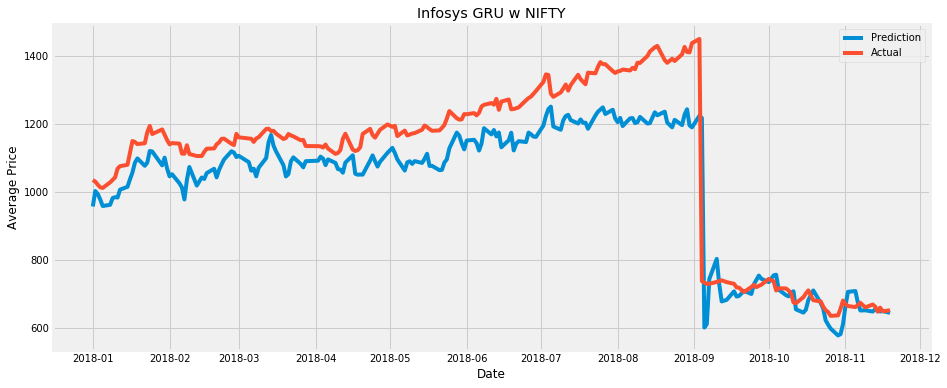

RMSE: 101.09426921023862
MAPE: 7.231762266928447


In [27]:
print('Scroll to the\nend for graph..')
company_w_nifty('../ml-project-data/INFY_train.csv', '../ml-project-data/INFY_test.csv', 'Infosys')

Scroll to the
end for graph..


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 6), kernel_initializer="he_uniform")`
  import sys


Training & evaluating GRU-RNN for batch size = 32...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 1s - loss: 0.3806
Epoch 2/150
 - 0s - loss: 0.1298
Epoch 3/150
 - 0s - loss: 0.0649
Epoch 4/150
 - 0s - loss: 0.1275
Epoch 5/150
 - 0s - loss: 0.1705
Epoch 6/150
 - 0s - loss: 0.1584
Epoch 7/150
 - 0s - loss: 0.1210
Epoch 8/150
 - 0s - loss: 0.0772
Epoch 9/150
 - 0s - loss: 0.0569
Epoch 10/150
 - 0s - loss: 0.0618
Epoch 11/150
 - 0s - loss: 0.0713
Epoch 12/150
 - 0s - loss: 0.0837
Epoch 13/150
 - 0s - loss: 0.0859
Epoch 14/150
 - 0s - loss: 0.0869
Epoch 15/150
 - 0s - loss: 0.0768
Epoch 16/150
 - 0s - loss: 0.0644
Epoch 17/150
 - 0s - loss: 0.0586
Epoch 18/150
 - 0s - loss: 0.0553
Epoch 19/150
 - 0s - loss: 0.0488
Epoch 20/150
 - 0s - loss: 0.0583
Epoch 21/150
 - 0s - loss: 0.0573
Epoch 22/150
 - 0s - loss: 0.0608
Epoch 23/150
 - 0s - loss: 0.0619
Epoch 24/150
 - 0s - loss: 0.0606
Epoch 25/150
 - 0s - loss: 0.0541
Epoch 26/150
 - 0s - loss: 0.0518
Epoch 27/150
 - 0s - loss: 0.0535
Epoch 28/150
 - 0s - loss: 0.0455
Epoch 29/150
 - 0s - loss: 0.0554
Epoch 30/150
 - 0s - lo

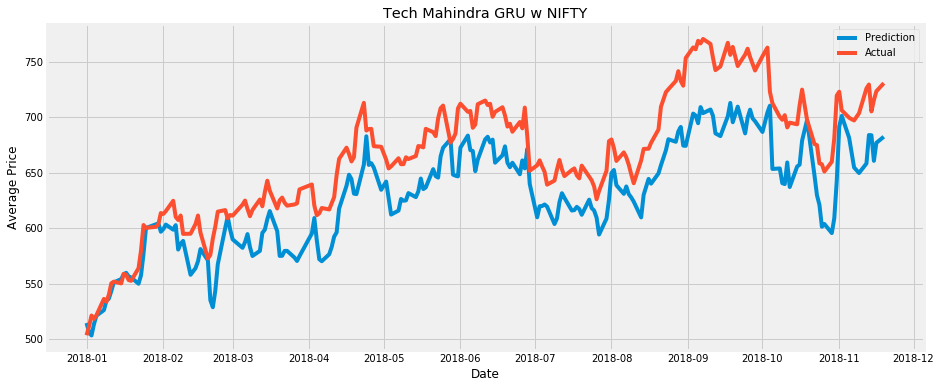

RMSE: 39.60142960542171
MAPE: 5.181458330231272


In [14]:
print('Scroll to the\nend for graph..')
company_w_nifty('../ml-project-data/TECHM_train.csv', '../ml-project-data/TECHM_test.csv', 'Tech Mahindra')

Scroll to the
end for graph..


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, input_shape=(None, 6), kernel_initializer="he_uniform")`
  import sys


Training & evaluating GRU-RNN for batch size = 32...


C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  if __name__ == '__main__':
C:\Users\Colossus\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Epoch 1/150
 - 2s - loss: 0.4601
Epoch 2/150
 - 0s - loss: 0.1515
Epoch 3/150
 - 0s - loss: 0.1581
Epoch 4/150
 - 0s - loss: 0.2529
Epoch 5/150
 - 0s - loss: 0.2207
Epoch 6/150
 - 0s - loss: 0.1529
Epoch 7/150
 - 0s - loss: 0.0952
Epoch 8/150
 - 0s - loss: 0.0977
Epoch 9/150
 - 0s - loss: 0.1147
Epoch 10/150
 - 0s - loss: 0.1528
Epoch 11/150
 - 0s - loss: 0.1485
Epoch 12/150
 - 0s - loss: 0.1244
Epoch 13/150
 - 0s - loss: 0.1112
Epoch 14/150
 - 0s - loss: 0.0893
Epoch 15/150
 - 0s - loss: 0.0827
Epoch 16/150
 - 0s - loss: 0.0981
Epoch 17/150
 - 0s - loss: 0.1084
Epoch 18/150
 - 0s - loss: 0.1119
Epoch 19/150
 - 0s - loss: 0.0968
Epoch 20/150
 - 0s - loss: 0.0944
Epoch 21/150
 - 0s - loss: 0.0778
Epoch 22/150
 - 0s - loss: 0.0781
Epoch 23/150
 - 0s - loss: 0.0810
Epoch 24/150
 - 0s - loss: 0.0936
Epoch 25/150
 - 0s - loss: 0.0920
Epoch 26/150
 - 0s - loss: 0.0937
Epoch 27/150
 - 0s - loss: 0.0890
Epoch 28/150
 - 0s - loss: 0.0782
Epoch 29/150
 - 0s - loss: 0.0802
Epoch 30/150
 - 0s - lo

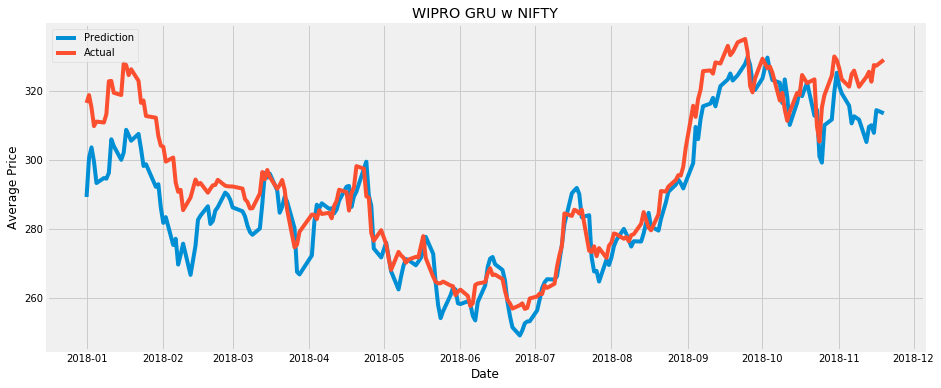

RMSE: 9.376637385138418
MAPE: 2.3760725854740974


In [29]:
print('Scroll to the\nend for graph..')
company_w_nifty('../ml-project-data/WIPRO_train.csv', '../ml-project-data/WIPRO_test.csv', 'WIPRO')